## **Problem Statement**

A microblogging and social networking service provider company wants to automatically tag and analyze tweets for better understanding of the trends and topics without being dependent on the hashtags that the users use. Many users do not use hashtags or sometimes use wrong or mis-spelled tags, so they want to completely remove this problem and create a system of recognizing important content of the tweets.

**Concept** : Named Entity Recognition (NER) is an important subtask of information extraction that seeks to locate and recognise named entities.

**Task** : Train models that will be able to identify the various named entities.

## **Data Description**

Dataset is annotated with 10 fine-grained NER categories:
1. person
2. geo-location
3. company
4. facility
5. product
6. music artist
7. movie
8. sports team
9. tv show
10. other

Dataset was extracted from tweets and is structured in CoNLL format, in English language contained in Text file format.

The CoNLL format is a text file with one word per line with sentences separated by an empty line. The first word in a line should be the word and the last word should be the label.

## **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import string
import re
import datetime

import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
import gensim.downloader
from gensim.models import KeyedVectors

In [ ]:
pip install tensorflow_addons

In [ ]:
pip install datasets transformers

In [ ]:
pip install plot-keras-history

In [ ]:
pip install seqeval

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from seqeval.metrics import accuracy_score, f1_score, classification_report

import tensorflow as tf
import keras as k

from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow_addons as tfa
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW

from plot_keras_history import plot_history

from transformers import BertTokenizer, TFBertForTokenClassification

tf.random.set_seed(111)
np.random.seed(88)

## **Loading and formatting the data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(filename: str):
  # Conll file is stored as (token, tag) pairs, one per line
  # Extracting data from conll files
  with open(filename, 'r') as file:
    lines = [line[:-1].split() for line in file] # Skipping last line as it will be a blank space
  samples, start = [], 0
  for end, parts in enumerate(lines):
      if not parts:
          sample = [(token, tag)
                      for token, tag in lines[start:end]]
          samples.append(sample)
          start = end + 1
  if start < end:
    samples.append(lines[start:end])
  return samples

train_samples = load_data('/content/drive/MyDrive/Colab Notebooks/Data/wnut 16.txt.conll')
test_samples = load_data('/content/drive/MyDrive/Colab Notebooks/Data/wnut 16test.txt.conll')
samples = train_samples + test_samples
schema = ['_'] + sorted({tag for sentence in samples
                             for _, tag in sentence}) # '_' is used to indicate a null (blank) token.

In [ ]:
schema

['_',
 'B-company',
 'B-facility',
 'B-geo-loc',
 'B-movie',
 'B-musicartist',
 'B-other',
 'B-person',
 'B-product',
 'B-sportsteam',
 'B-tvshow',
 'I-company',
 'I-facility',
 'I-geo-loc',
 'I-movie',
 'I-musicartist',
 'I-other',
 'I-person',
 'I-product',
 'I-sportsteam',
 'I-tvshow',
 'O']

In [ ]:
train_samples[1]

[('Made', 'O'),
 ('it', 'O'),
 ('back', 'O'),
 ('home', 'O'),
 ('to', 'O'),
 ('GA', 'B-geo-loc'),
 ('.', 'O'),
 ('It', 'O'),
 ('sucks', 'O'),
 ('not', 'O'),
 ('to', 'O'),
 ('be', 'O'),
 ('at', 'O'),
 ('Disney', 'B-facility'),
 ('world', 'I-facility'),
 (',', 'O'),
 ('but', 'O'),
 ('its', 'O'),
 ('good', 'O'),
 ('to', 'O'),
 ('be', 'O'),
 ('home', 'O'),
 ('.', 'O'),
 ('Time', 'O'),
 ('to', 'O'),
 ('start', 'O'),
 ('planning', 'O'),
 ('the', 'O'),
 ('next', 'O'),
 ('Disney', 'B-facility'),
 ('World', 'I-facility'),
 ('trip', 'O'),
 ('.', 'O')]

In [ ]:
len(train_samples), len(list(range(1,len(train_samples)+1)))

(2394, 2394)

## **Understanding Structure of the Data**

In [ ]:
tweets_train = []

for i, sample in tqdm(zip(list(range(1,len(train_samples)+1)), train_samples), total=len(train_samples)):
  current_tweet_train = []
  for content in sample:
    word, label = content
    current_tweet_train.append(('Tweet: '+ str(i), word, label))
  tweets_train.append(current_tweet_train)

  0%|          | 0/2394 [00:00<?, ?it/s]

In [ ]:
len(tweets_train)

2394

In [ ]:
len(tweets_train[0])

12

In [ ]:
tweets_train_df = pd.DataFrame({'Tweet_#':[tweet_content[0] for tweet in tweets_train for tweet_content in tweet],
                                'Word':[tweet_content[1] for tweet in tweets_train for tweet_content in tweet],
                                'NER_Tag':[tweet_content[2] for tweet in tweets_train for tweet_content in tweet],})

In [ ]:
tweets_train_df

,Tweet_#,Word,NER_Tag
0,Tweet: 1,@SammieLynnsMom,O
1,Tweet: 1,@tg10781,O
2,Tweet: 1,they,O
3,Tweet: 1,will,O
4,Tweet: 1,be,O
...,...,...,...
46463,Tweet: 2394,friday,O
46464,Tweet: 2394,whatchu,O
46465,Tweet: 2394,got,O
46466,Tweet: 2394,for,O


## **Tag information**

- B-* Start token for a tag
- I-* Continuation tokens for a tag

In [ ]:
def tags_combine(text):
  if text == 'O':
    return text
  else:
    text = text.split('-', maxsplit=1)
    word = ''
    for ele in text:
      if ele not in ['B', 'I']:
        word += ele
    return word

In [ ]:
tweets_train_df['NER_Tag_'] = tweets_train_df['NER_Tag'].progress_apply(tags_combine)

  0%|          | 0/46468 [00:00<?, ?it/s]

In [ ]:
tweets_train_df

,Tweet_#,Word,NER_Tag,NER_Tag_
0,Tweet: 1,@SammieLynnsMom,O,O
1,Tweet: 1,@tg10781,O,O
2,Tweet: 1,they,O,O
3,Tweet: 1,will,O,O
4,Tweet: 1,be,O,O
...,...,...,...,...
46463,Tweet: 2394,friday,O,O
46464,Tweet: 2394,whatchu,O,O
46465,Tweet: 2394,got,O,O
46466,Tweet: 2394,for,O,O


### **Checking the structure & characteristics of the train dataset**

In [ ]:
print('Shape of the train data :', tweets_train_df.shape)

Shape of the train data : (46468, 4)


In [ ]:
print("Number of tweets in train data: ", len(tweets_train_df.groupby(['Tweet_#'])))

Number of tweets in train data:  2394


In [ ]:
words = list(set(tweets_train_df["Word"].values))
n_words = len(words)
print("Number of unique words in the train dataset: ", n_words)

Number of unique words in the train dataset:  10586


In [ ]:
n_tags = len(tweets_train_df.groupby(['NER_Tag']))
print("Number of Labels in train data: ", n_tags)

Number of Labels in train data:  21


In [ ]:
tags = tweets_train_df["NER_Tag"].unique()
print("Tags in train data:", tags)


Tags in train data: ['O' 'B-geo-loc' 'B-facility' 'I-facility' 'B-movie' 'I-movie' 'B-company'
 'B-product' 'B-person' 'B-other' 'I-other' 'B-sportsteam' 'I-sportsteam'
 'I-product' 'I-company' 'I-person' 'I-geo-loc' 'B-tvshow' 'B-musicartist'
 'I-musicartist' 'I-tvshow']


In [ ]:
#let's check the frequency of each NER tag
tweets_train_df['NER_Tag_'].value_counts()

O              44006
person           664
other            545
geo-loc          325
facility         209
company          207
product          177
musicartist      116
movie             80
sportsteam        74
tvshow            65
Name: NER_Tag_, dtype: int64

<Axes: >

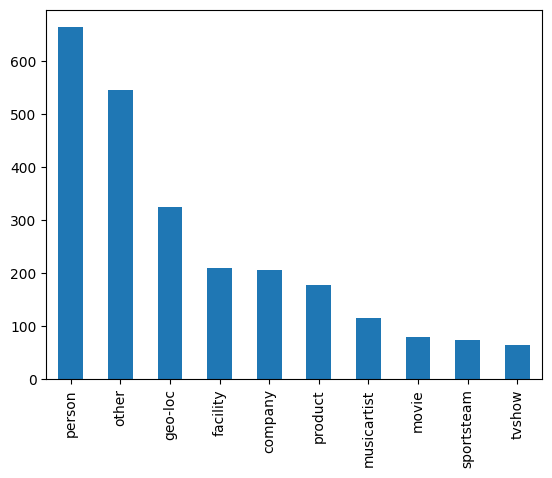

In [ ]:
tweets_train_df[tweets_train_df['NER_Tag_']!='O']['NER_Tag_'].value_counts().plot(kind='bar')

<Axes: >

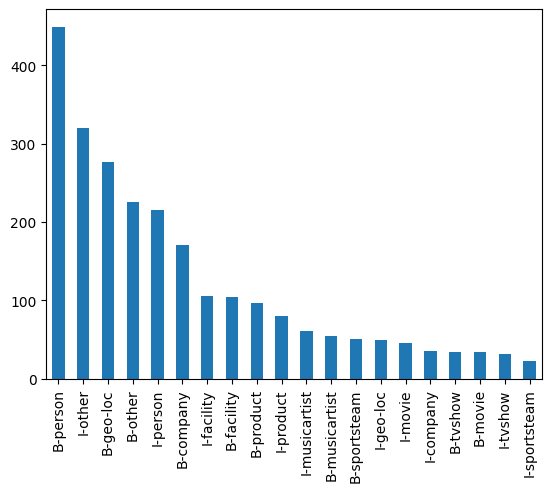

In [ ]:
tweets_train_df[tweets_train_df['NER_Tag']!='O']['NER_Tag'].value_counts().plot(kind='bar')

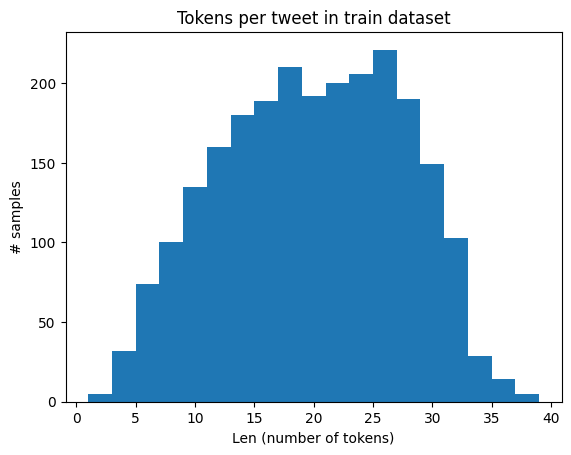

In [ ]:
# Plot tweets by lenght
plt.hist([len(tw) for tw in tweets_train], bins=19)
plt.title('Tokens per tweet in train dataset')
plt.xlabel('Len (number of tokens)')
plt.ylabel('# samples')
plt.show()

## **Data preprocessing**

In [ ]:
from collections import defaultdict
all_samples = train_samples
all_samples.extend(test_samples)

word_counts = defaultdict(int) # Calculate vocab size
max_len = 0 # Calculate max length of a sentence

for sample in all_samples:
  for word in sample:
    word_counts[word[0]]+=1

  max_len = max(max_len, len(sample))

n_words = len(word_counts.items())


print("*"*30)
print("Max Length: ", max_len)
print("Vocab Size: ", n_words)

******************************
Max Length:  39
Vocab Size:  25382


### **Getting the correct word embedding model and tokenizer**

In [ ]:
glove_vectors = gensim.downloader.load("glove-twitter-200")

In [ ]:
embedding_dim = glove_vectors.vector_size

In [ ]:
crf_tokenizer = Tokenizer(num_words=n_words, lower=True)

### **Data preprocessing and tokenization**

In [ ]:
all_sentences = [] # Concating test, train sentences. To train a tokenizer

for tweet in all_samples:
  sentence = [tweet_content[0] for tweet_content in tweet]
  all_sentences.append(sentence)

crf_tokenizer.fit_on_texts(all_sentences)

In [ ]:
print(len(crf_tokenizer.word_index))

21933


In [ ]:
tag2id = {} # Label to indicies mapping
id2tag = {} # Index to label mapping
for i, tag in enumerate(schema):
  tag2id[tag] = i
  id2tag[i] = tag

In [ ]:
tag2id, id2tag

({'_': 0,
  'B-company': 1,
  'B-facility': 2,
  'B-geo-loc': 3,
  'B-movie': 4,
  'B-musicartist': 5,
  'B-other': 6,
  'B-person': 7,
  'B-product': 8,
  'B-sportsteam': 9,
  'B-tvshow': 10,
  'I-company': 11,
  'I-facility': 12,
  'I-geo-loc': 13,
  'I-movie': 14,
  'I-musicartist': 15,
  'I-other': 16,
  'I-person': 17,
  'I-product': 18,
  'I-sportsteam': 19,
  'I-tvshow': 20,
  'O': 21},
 {0: '_',
  1: 'B-company',
  2: 'B-facility',
  3: 'B-geo-loc',
  4: 'B-movie',
  5: 'B-musicartist',
  6: 'B-other',
  7: 'B-person',
  8: 'B-product',
  9: 'B-sportsteam',
  10: 'B-tvshow',
  11: 'I-company',
  12: 'I-facility',
  13: 'I-geo-loc',
  14: 'I-movie',
  15: 'I-musicartist',
  16: 'I-other',
  17: 'I-person',
  18: 'I-product',
  19: 'I-sportsteam',
  20: 'I-tvshow',
  21: 'O'})

In [ ]:
num_tokens = len(crf_tokenizer.word_index) + 1
hits = 0
misses = 0
missed_words = []


# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in crf_tokenizer.word_index.items():
  embedding_vector = None
  try:
    embedding_vector = glove_vectors[word]
  except Exception :
    pass

  if embedding_vector is not None:
    # Words not found in embedding index will be all-zeros.
    # This includes the representation for "padding" and "OOV"
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    missed_words.append(word)
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 11495 words (10438 misses)


## **Train test split the data**

In [ ]:
def get_dataset(samples, max_len, tag2id, tokenizer):
  '''Prepares the input dataset

  Args:
    `samples`: List[List[Tuple[word, tag]]], input data
    `max_len`: Maximum input length
    `tag2id`: Mapping[tag: integer]
    `tokenizer`: Tensorflow tokenizer, for tokenizing input sequence

  Returns:
    Tuple[np.ndarray, np.ndarray]: sentences and it's labels
  '''
  dataset = {'samples':[], 'labels': []}

  for sample in samples:
    # Extracting inputs and labels
    inputs = [x[0] for x in sample]
    outputs = [x[1] for x in sample]

    # Tokenizing inputs
    inputs = tokenizer.texts_to_sequences([inputs])[0]

    # padding labels
    padded_inputs = [inputs[i] if i < len(inputs) else 0 for i in range(max_len)]

    # Initializing labels as One Hot Encoded Vectors
    padded_labels = [[0 for i in range(len(tag2id))] for j in range(max_len)]
    for i in range(len(outputs)):
      padded_labels[i][tag2id[outputs[i]]] = 1

    # Adding padded inputs & labels to dataset
    dataset['samples'].append(padded_inputs)
    dataset['labels'].append(padded_labels)

  return np.array(dataset['samples']), np.array(dataset['labels'])

train_sentences, train_labels = get_dataset(train_samples, max_len, tag2id, crf_tokenizer)
test_sentences, test_labels = get_dataset(test_samples, max_len, tag2id, crf_tokenizer)

In [ ]:
train_sentences[0]

array([5791, 5792,  107,   51,   23,   52,  277,   61,   81,  834,   36,
       5793,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [ ]:
train_labels[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0,

## **Training a Bi-LSTM + CRF Model**

In [ ]:
def build_model():
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(input_dim=embedding_matrix.shape[0],
                      output_dim=embedding_dim,
                      input_length=max_len, mask_zero=True,
                      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
                    )(input)

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)

  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  # CRF layer
  crf = CRF(len(schema), name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

In [ ]:
model = build_model()

# Model Checkpointing
save_model = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/logs/checkpoint/twitter_ner_crf.h5',
                             monitor='val_loss',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)

# Early stopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 embedding (Embedding)       (None, 39, 200)           4386800   
                                                                 
 bidirectional (Bidirectiona  (None, 39, 100)          100400    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 39, 100)          60400     
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 39, 25)           2525      
 ibuted)                                                         
                                                             

## **Training our model**

In [ ]:
history = model.fit(train_sentences, train_labels,
                    validation_data = (test_sentences, test_labels),
                    epochs = 300,
                    callbacks  = callbacks,
                    shuffle=True)

Epoch 1/300


195/196 [============================>.] - ETA: 0s - loss: 0.0788
Epoch 1: val_loss improved from inf to 0.04469, saving model to /content/drive/MyDrive/Colab Notebooks/logs/checkpoint/twitter_ner_crf.h5
196/196 [==============================] - 35s 74ms/step - loss: 0.0788 - val_loss: 0.0447
Epoch 2/300
195/196 [============================>.] - ETA: 0s - loss: 0.0383
Epoch 2: val_loss improved from 0.04469 to 0.03791, saving model to /content/drive/MyDrive/Colab Notebooks/logs/checkpoint/twitter_ner_crf.h5
196/196 [==============================] - 8s 42ms/step - loss: 0.0383 - val_loss: 0.0379
Epoch 3/300
196/196 [==============================] - ETA: 0s - loss: 0.0322
Epoch 3: val_loss improved from 0.03791 to 0.03103, saving model to /content/drive/MyDrive/Colab Notebooks/logs/checkpoint/twitter_ner_crf.h5
196/196 [==============================] - 11s 55ms/step - loss: 0.0322 - val_loss: 0.0310
Epoch 4/300
196/196 [==============================] - ETA: 0s - loss: 0.0262
Epoch 

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>)

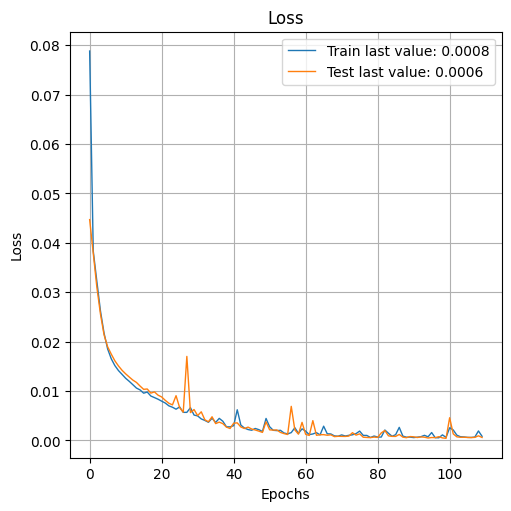

In [ ]:
plot_history(history.history)

## **Let's load the best model**

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/logs/checkpoint/twitter_ner_crf.h5')

In [ ]:
crf_model = tf.keras.Model(inputs=model.input, outputs=[model.output, model.get_layer('crf').output, model.input])

## **Align labels to input**

In [ ]:
y_pred, _, _ = crf_model.predict(test_sentences)
pred_labels = np.argmax(y_pred, axis=-1)
true_labels = np.argmax(test_labels, axis=-1)

121/121 [==============================] - 7s 55ms/step


In [ ]:
idx = 123
test_sentences[idx]

array([ 965,  739,  371,   61,  415,  116,   40,  966,  879,   11, 1501,
          2,  965,  739,  109,  601,    9,    4,  546,   16, 2096,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [ ]:
true_labels[idx]

array([ 1, 11, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,  1, 11, 21, 21, 21,
       21, 21, 21, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [ ]:
pred_labels[idx]

array([ 1, 11, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,  1, 11, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21])

In [ ]:
true_labels_map = []
for tags in true_labels:
  tags_map = []
  for idx in tags:
    tags_map.append(id2tag[idx])
  true_labels_map.append(tags_map)

In [ ]:
pred_labels_map = []
for tags in pred_labels:
  tags_map = []
  for idx in tags:
    tags_map.append(id2tag[idx])
  pred_labels_map.append(tags_map)

### **Compute metrics to show effectiveness of trained model**

In [ ]:
def calculate_accuracy(y_true, y_pred):
  '''Convert categorical one hot encodings to indices and compute accuracy

  Args:
    `y_true`: true values
    `y_pred`: model predictions

  Returns:
    Integer, accuracy of prediction
  '''
  acc_metric = tf.keras.metrics.Accuracy()
  y_true = tf.argmax(y_true, axis=-1)
  return acc_metric(y_true, y_pred).numpy().item()

def calculate_model_accuracy(crf_model, test_sentences, test_labels):
  '''Calculates average validation accuracy of model'''

  # Batch the dataset
  batched_validation_set = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels)).batch(32)

  average_acc = 0
  # Iterate through batches
  for batch_test_sentences, batch_test_labels in batched_validation_set:
    predicted_labels, _, _, _ = crf_model(batch_test_sentences)[1]
    average_acc += calculate_accuracy(batch_test_labels, predicted_labels)

  average_acc/=len(batched_validation_set)
  return average_acc

average_acc = calculate_model_accuracy(crf_model, test_sentences, test_labels)

print("*"*32)
print(f"Average accuracy of model on test set: {average_acc:.3f}")

********************************
Average accuracy of model on test set: 0.996


In [ ]:
print("F1 score:", f1_score(true_labels_map, pred_labels_map))
print(classification_report(true_labels_map, pred_labels_map))

accuracy score: 0.4120945720945721
F1 score: 0.994241289951051
              precision    recall  f1-score   support

     company       1.00      1.00      1.00       621
    facility       1.00      1.00      1.00       253
     geo-loc       0.99      1.00      0.99       882
       movie       0.97      0.97      0.97        34
 musicartist       0.99      0.98      0.99       191
       other       0.99      0.99      0.99       584
      person       0.99      1.00      1.00       482
     product       0.99      0.99      0.99       246
  sportsteam       1.00      1.00      1.00       147
      tvshow       1.00      1.00      1.00        33

   micro avg       0.99      0.99      0.99      3473
   macro avg       0.99      0.99      0.99      3473
weighted avg       0.99      0.99      0.99      3473



## **BERT Model**

### **Getting the bert model**

In [ ]:
from transformers import AutoConfig, TFAutoModelForTokenClassification

MODEL_NAME = 'bert-base-uncased'

### **Loading the tokenizer**

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # Load bert-base-uncased tokenizer

In [ ]:
## tokenizer adds 101 and 102 token id at the start and end of the tokens
## using[1:-1] to eliminate the extra 101, 102 that tokenizer adds

sample=train_samples[23] # Random tokenized sample
for token, tag in sample:
  for subtoken in tokenizer(token)['input_ids'][1:-1]:
    print(token,subtoken)

RT 19387
@OMBieberJokes 1030
@OMBieberJokes 18168
@OMBieberJokes 11283
@OMBieberJokes 5677
@OMBieberJokes 5558
@OMBieberJokes 9681
: 1024
Little 2210
Girl 2611
: 1024
Santa 4203
Is 2003
So 2061
Awesome 12476
! 999
Me 2033
: 1024
No 2053
Little 2210
Girl 2611
... 1012
... 1012
... 1012
You 2017
Only 2069
Use 2224
The 1996
Word 2773
" 1000
Awesome 12476
" 1000
When 2043
You 2017
Are 2024
Referring 7727
To 2000
Just 2074
... 1012
... 1012
... 1012


### **Get Datasets**

In [ ]:
def tokenize_sample(sample):
  # Expand label to all subtokens and add 'O' label to start and end tokens
  seq = [
    (subtoken, tag)
    for token, tag in sample
    for subtoken in tokenizer(token.lower())['input_ids'][1:-1]
  ]
  return [(3, 'O')] + seq + [(4, 'O')]

def preprocess(samples, tag2id):
  tokenized_samples = list((map(tokenize_sample, samples)))
  max_len = max(map(len, tokenized_samples))

  # Subtokens
  X_input_ids = np.zeros((len(samples), max_len), dtype=np.int32)

  # Masks
  X_input_masks = np.zeros((len(samples), max_len), dtype=np.int32)

  # labels
  y = np.zeros((len(samples), max_len), dtype=np.int32)

  for i, sentence in enumerate(tokenized_samples):
    for j in range(len(sentence)):
      X_input_masks[i, j] = 1
    for j, (subtoken_id, tag) in enumerate(sentence):
      X_input_ids[i, j] = subtoken_id
      y[i, j] = tag2id[tag]
  return (X_input_ids, X_input_masks), y

X_train, y_train = preprocess(train_samples, tag2id)
X_test, y_test = preprocess(test_samples, tag2id)

### **Loading model**

In [ ]:
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(schema),
                                    id2tag=id2tag, tag2id=tag2id) # Bert config

model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME,
                                                          config=config) # Loading Bert model
model.summary()

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  16918     
                                                                 
Total params: 108,908,566
Trainable params: 108,908,566
Non-trainable params: 0
_________________________________________________________________


### **Fit model on training data**

In [ ]:
BATCH_SIZE=32

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # Creating optimizer

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=metric)

history = model.fit(X_train, y_train,
                  validation_split=0.2, epochs=10,
                  batch_size=BATCH_SIZE)

Epoch 1/10
157/157 [==============================] - 283s 1s/step - loss: 0.1689 - accuracy: 0.9644 - val_loss: 0.0791 - val_accuracy: 0.9845
Epoch 2/10
157/157 [==============================] - 165s 1s/step - loss: 0.0496 - accuracy: 0.9889 - val_loss: 0.0471 - val_accuracy: 0.9880
Epoch 3/10
157/157 [==============================] - 165s 1s/step - loss: 0.0314 - accuracy: 0.9920 - val_loss: 0.0452 - val_accuracy: 0.9899
Epoch 4/10
157/157 [==============================] - 173s 1s/step - loss: 0.0201 - accuracy: 0.9947 - val_loss: 0.0389 - val_accuracy: 0.9913
Epoch 5/10
157/157 [==============================] - 173s 1s/step - loss: 0.0129 - accuracy: 0.9967 - val_loss: 0.0410 - val_accuracy: 0.9904
Epoch 6/10
157/157 [==============================] - 173s 1s/step - loss: 0.0099 - accuracy: 0.9975 - val_loss: 0.0417 - val_accuracy: 0.9907
Epoch 7/10
157/157 [==============================] - 175s 1s/step - loss: 0.0072 - accuracy: 0.9981 - val_loss: 0.0417 - val_accuracy: 0.9914

In [ ]:
## Lets have a side by side view of true labels and model predictions
## Arranged as an array of Tuple(token, true label, model prediction)

def aggregate(sample, predictions):
  results = []
  i = 1
  for token, y_true in sample:
      nr_subtoken = len(tokenizer(token.lower())['input_ids']) - 2 # Extracting word tokens
      pred = predictions[i:i+nr_subtoken] # Extracting predictions
      i += nr_subtoken
      y_pred = schema[np.argmax(np.sum(pred, axis=0))] # Get label of prediction
      results.append((token, y_true, y_pred))
  return results

y_probs = model.predict(X_test)[0]
predictions = [aggregate(sample, predictions)
               for sample, predictions in zip(test_samples, y_probs)]

121/121 [==============================] - 45s 333ms/step


In [ ]:
for i in range(10,15):
  print(predictions[i])

[('I', 'O', 'O'), ('drive', 'O', 'O'), ('by', 'O', 'O'), ('that', 'O', 'O'), ('motel', 'O', 'O'), ('almost', 'O', 'O'), ('every', 'O', 'O'), ('night', 'O', 'O'), ('.', 'O', 'O'), ('#MesaShooting', 'O', 'O')]
[('Apple', 'B-product', 'B-product'), ('MacBook', 'I-product', 'I-product'), ('Pro', 'I-product', 'I-product'), ('A1278', 'I-product', 'I-product'), ('13.3', 'I-product', 'I-product'), ('"', 'I-product', 'I-product'), ('Laptop', 'I-product', 'I-product'), ('-', 'I-product', 'I-product'), ('MD101LL/A', 'I-product', 'I-product'), ('(', 'O', 'O'), ('June', 'O', 'O'), (',', 'O', 'O'), ('2012', 'O', 'O'), (')', 'O', 'O'), ('-', 'O', 'O'), ('Full', 'O', 'O'), ('read', 'O', 'O'), ('by', 'O', 'O'), ('eBay', 'B-company', 'B-company'), ('http://t.co/2zgQ99nmuf', 'O', 'O'), ('http://t.co/eQmogqqABK', 'O', 'O')]
[('Tuff', 'B-musicartist', 'B-musicartist'), ('Culture', 'I-musicartist', 'I-musicartist'), ('-', 'O', 'O'), ('Destiny', 'B-product', 'B-product'), ('EP', 'O', 'O'), ('(', 'O', 'O'), (

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/logs/checkpoint/NER_pretrained")

## **Comparision**

In [ ]:
def tokenize_bert(sentence):
  sentence_tokens = tokenizer(sentence.split(' '))['input_ids'] # Splitting sentence into word tokens
  ner_tokens = [3] # Start token
  for word_token in sentence_tokens:
    ner_tokens.extend(word_token[1:-1]) # Adding tokenized word token indicies
  ner_tokens += [4] # End token
  return ner_tokens

In [ ]:
sentence = "virat kohli is goat but sachine tendulkar is god of cricket for indian cricket fans !!"

# Bert tokenization
bert_tokens = tokenize_bert(sentence)

# CRF tokenization
crf_tokens = crf_tokenizer.texts_to_sequences([sentence])

In [ ]:
bert_tokens

[3,
 6819,
 8609,
 12849,
 27766,
 2003,
 13555,
 2021,
 17266,
 14014,
 7166,
 5313,
 6673,
 2003,
 2643,
 1997,
 4533,
 2005,
 2796,
 4533,
 4599,
 999,
 999,
 4]

In [ ]:
crf_tokens

[[19, 44, 15094, 19, 250, 15, 3827, 14, 3240, 3827, 814]]

### **Bert Output**

In [ ]:
def align_labels_to_input(sentence, predictions):
  sentence_tokens = sentence.lower().split(" ")
  results = []

  i = 1
  # Extracting labels corresponding to tokens
  for token in sentence_tokens:
      nr_subtoken = len(tokenizer(token)['input_ids']) - 2
      pred = predictions[i:i+nr_subtoken]
      i += nr_subtoken
      y_pred = id2tag[np.argmax(np.sum(pred, axis=0))]
      results.append((token, y_pred))
  return results


bert_logits = model.predict([bert_tokens], verbose=0).logits

align_labels_to_input(sentence, bert_logits[0])

[('virat', 'B-person'),
 ('kohli', 'I-person'),
 ('is', 'O'),
 ('goat', 'O'),
 ('but', 'O'),
 ('sachine', 'O'),
 ('tendulkar', 'O'),
 ('is', 'O'),
 ('god', 'O'),
 ('of', 'O'),
 ('cricket', 'O'),
 ('for', 'O'),
 ('indian', 'B-other'),
 ('cricket', 'I-other'),
 ('fans', 'O'),
 ('!!', 'O')]

### **CRF Output**

In [ ]:
from pprint import pprint # Pretty print package

crf_padded_tokens = [[crf_tokens[0][x] if x < len(crf_tokens[0]) else 0 for x in range(39)]]
crf_preds, _, _, _ = crf_model.predict(crf_padded_tokens, verbose=0)[1]

crf_preds = [id2tag[x] for x in crf_preds[0]] # Convert indicies into predictions


# Get aligned inputs with labels
input_word_tokens = [crf_tokenizer.sequences_to_texts([[x]])[0] for x in crf_padded_tokens[0]]

# Only printing non-padded tokens with their labels
pprint(list(zip(input_word_tokens[:len(crf_tokens[0])], crf_preds[:len(crf_tokens[0])])))

[('is', 'O'),
 ('but', 'O'),
 ('tendulkar', 'O'),
 ('is', 'O'),
 ('god', 'B-person'),
 ('of', 'O'),
 ('cricket', 'O'),
 ('for', 'O'),
 ('indian', 'B-person'),
 ('cricket', 'O'),
 ('fans', 'O')]


In [ ]:
crf_padded_tokens

[[19,
  44,
  15094,
  19,
  250,
  15,
  3827,
  14,
  3240,
  3827,
  814,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]]